In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import rpy2
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir = "/home/sparrow/JHU/gtex_stats/"
out_dir = "/home/sparrow/JHU/tx_noise/"
hg38_fa = "/home/sparrow/genomicData/hg38/hg38_p8.fa"

readlen = 101

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

real_counts_path = out_dir+"/sim_samples/res_distrib.real.sample0/sim_counts_matrix"
nonint_counts_path = out_dir+"/sim_samples/res_distrib.nonint.sample0/sim_counts_matrix"
int_counts_path = out_dir+"/sim_samples/res_distrib.int.sample0/sim_counts_matrix"
pol_counts_path = out_dir+"/sim_samples/res_distrib.pol.sample0/sim_counts_matrix"

In [3]:
# begin by preprocessing the rda n R if not possible to load through python
#   from here need to get:
#      1. number of reads
#      2. TPM
#      3. transcript name
#      4. transcript type
#      5. gene type
# next need to get the TPM and transcript names from the results

In [4]:
# first perform the conversion from .rda to .csv
r_cmd = ["R","-e",
         "load(file = \""+real_counts_path+".rda"+"\");write.csv(counts_matrix,\""+real_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)
r_cmd = ["R","-e",
         "load(file = \""+nonint_counts_path+".rda"+"\");write.csv(counts_matrix,\""+nonint_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)
r_cmd = ["R","-e",
         "load(file = \""+int_counts_path+".rda"+"\");write.csv(counts_matrix,\""+int_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)
r_cmd = ["R","-e",
         "load(file = \""+pol_counts_path+".rda"+"\");write.csv(counts_matrix,\""+pol_counts_path+".csv"+"\",quote=FALSE)"]
subprocess.call(r_cmd)

0

In [5]:
# now can load respective datasets
realDF = pd.read_csv(real_counts_path+".csv")
realDF.columns = ["tid","npairs"]
nonintDF = pd.read_csv(nonint_counts_path+".csv")
nonintDF.columns = ["tid","npairs"]
intDF = pd.read_csv(int_counts_path+".csv")
intDF.columns = ["tid","npairs"]
polDF = pd.read_csv(pol_counts_path+".csv")
polDF.columns = ["tid","npairs"]

In [6]:
# make sure there is no overlap in transcriptIDs
all_tids = realDF["tid"].to_list()
all_tids.extend(nonintDF["tid"].to_list())
all_tids.extend(intDF["tid"].to_list())
all_tids.extend(polDF["tid"].to_list())
assert len(all_tids)==len(set(all_tids)),"duplicate tids"

In [7]:
# now can load salmon outputs and add it to the realDF
slmn_real = pd.read_csv(out_dir+"sim_samples/slmn.real.sample0/quant.sf",sep="\t")
slmn_real.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real.columns = ["tid","slmn_real_nreads"]
slmn_real_nonint = pd.read_csv(out_dir+"sim_samples/slmn.real_nonint.sample0/quant.sf",sep="\t")
slmn_real_nonint.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real_nonint.columns = ["tid","slmn_real_nonint_nreads"]
slmn_real_int = pd.read_csv(out_dir+"sim_samples/slmn.real_int.sample0/quant.sf",sep="\t")
slmn_real_int.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real_int.columns = ["tid","slmn_real_int_nreads"]
slmn_real_pol = pd.read_csv(out_dir+"sim_samples/slmn.real_pol.sample0/quant.sf",sep="\t")
slmn_real_pol.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_real_pol.columns = ["tid","slmn_real_pol_nreads"]
slmn_all = pd.read_csv(out_dir+"sim_samples/slmn.all.sample0/quant.sf",sep="\t")
slmn_all.drop(["Length","EffectiveLength","TPM"],axis=1,inplace=True)
slmn_all.columns = ["tid","slmn_all_nreads"]

In [9]:
# now can load salmon outputs and add it to the realDF
klst_real = pd.read_csv(out_dir+"sim_samples/klst.real.sample0/abundance.tsv",sep="\t")
klst_real.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real.columns = ["tid","klst_real_nreads"]
klst_real_nonint = pd.read_csv(out_dir+"sim_samples/klst.real_nonint.sample0/abundance.tsv",sep="\t")
klst_real_nonint.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real_nonint.columns = ["tid","klst_real_nonint_nreads"]
klst_real_int = pd.read_csv(out_dir+"sim_samples/klst.real_int.sample0/abundance.tsv",sep="\t")
klst_real_int.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real_int.columns = ["tid","klst_real_int_nreads"]
klst_real_pol = pd.read_csv(out_dir+"sim_samples/klst.real_pol.sample0/abundance.tsv",sep="\t")
klst_real_pol.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_real_pol.columns = ["tid","klst_real_pol_nreads"]
klst_all = pd.read_csv(out_dir+"sim_samples/klst.all.sample0/abundance.tsv",sep="\t")
klst_all.drop(["length","eff_length","tpm"],axis=1,inplace=True)
klst_all.columns = ["tid","klst_all_nreads"]

In [10]:
# the difficulty here is that I am not sure we are computing nreads for Stringtie correctly
# since coverages are uneven along the length of the transcript, which implies
# that the coverage is averaged, which implies that it might not be accurate

# now need to load stringtie assemblies and convert coverage to the number of reads
# for this we will need effective length of transcripts
strg_real=pd.read_csv(out_dir+"sim_samples/strg.real.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real.dropna(axis=0,inplace=True)
strg_real = strg_real[strg_real["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_exons=strg_real[strg_real["type"]=="exon"].reset_index(drop=True)
strg_real=strg_real[strg_real["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real["cov"]=strg_real["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real["cov"]=strg_real["cov"].astype(float)
strg_real["tid"]=strg_real["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real=strg_real[["tid","cov"]]
strg_real.columns=["tid","cov"]
strg_real.sort_values(by="tid")
assert len(strg_real[strg_real.duplicated("tid")])==0,"duplicate tids in strg_real"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_exons["tid"]=strg_real_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_exons["elen"] = strg_real_exons["end"]-strg_real_exons["start"]
strg_real_exons = strg_real_exons[["tid","elen"]]
strg_real_exons = strg_real_exons.groupby(by="tid").sum().reset_index()
strg_real = strg_real.merge(strg_real_exons,on="tid",how="left",indicator=True)
assert len(strg_real[strg_real["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real.drop("_merge",axis=1,inplace=True)
strg_real["cov"]=strg_real["cov"].fillna(value=np.nan)
strg_real["strg_real_nreads"]=(strg_real["cov"]*strg_real["elen"])/(readlen*2)
strg_real.drop(["cov","elen"],axis=1,inplace=True)
strg_real.head()

,tid,strg_real_nreads
0,ALL_00000021,17.780943
1,ALL_00407327,48.758854
2,ALL_00901672,40.594088
3,ALL_02554820,105.871976
4,ALL_02450908,10.076702


In [11]:
strg_real_nonint=pd.read_csv(out_dir+"sim_samples/strg.real_nonint.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real_nonint.dropna(axis=0,inplace=True)
strg_real_nonint = strg_real_nonint[strg_real_nonint["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_nonint_exons=strg_real_nonint[strg_real_nonint["type"]=="exon"].reset_index(drop=True)
strg_real_nonint=strg_real_nonint[strg_real_nonint["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real_nonint["cov"]=strg_real_nonint["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_nonint["cov"]=strg_real_nonint["cov"].astype(float)
strg_real_nonint["tid"]=strg_real_nonint["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_nonint=strg_real_nonint[["tid","cov"]]
strg_real_nonint.columns=["tid","cov"]
strg_real_nonint.sort_values(by="tid")
assert len(strg_real_nonint[strg_real_nonint.duplicated("tid")])==0,"duplicate tids in strg_real_nonint"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_nonint_exons["tid"]=strg_real_nonint_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_nonint_exons["elen"] = strg_real_nonint_exons["end"]-strg_real_nonint_exons["start"]
strg_real_nonint_exons = strg_real_nonint_exons[["tid","elen"]]
strg_real_nonint_exons = strg_real_nonint_exons.groupby(by="tid").sum().reset_index()
strg_real_nonint = strg_real_nonint.merge(strg_real_nonint_exons,on="tid",how="left",indicator=True)
assert len(strg_real_nonint[strg_real_nonint["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real_nonint.drop("_merge",axis=1,inplace=True)
strg_real_nonint["cov"]=strg_real_nonint["cov"].fillna(value=np.nan)
strg_real_nonint["strg_real_nonint_nreads"]=(strg_real_nonint["cov"]*strg_real_nonint["elen"])/(readlen*2)
strg_real_nonint.drop(["cov","elen"],axis=1,inplace=True)
strg_real_nonint.head()

,tid,strg_real_nonint_nreads
0,ALL_00206901,36.319194
1,ALL_01503556,1.246674
2,ALL_00884184,2.823433
3,ALL_00206922,62.210788
4,ALL_00206969,248.829923


In [12]:
strg_real_int=pd.read_csv(out_dir+"sim_samples/strg.real_int.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real_int.dropna(axis=0,inplace=True)
strg_real_int = strg_real_int[strg_real_int["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_int_exons=strg_real_int[strg_real_int["type"]=="exon"].reset_index(drop=True)
strg_real_int=strg_real_int[strg_real_int["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real_int["cov"]=strg_real_int["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_int["cov"]=strg_real_int["cov"].astype(float)
strg_real_int["tid"]=strg_real_int["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_int=strg_real_int[["tid","cov"]]
strg_real_int.columns=["tid","cov"]
strg_real_int.sort_values(by="tid")
assert len(strg_real_int[strg_real_int.duplicated("tid")])==0,"duplicate tids in strg_real_int"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_int_exons["tid"]=strg_real_int_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_int_exons["elen"] = strg_real_int_exons["end"]-strg_real_int_exons["start"]
strg_real_int_exons = strg_real_int_exons[["tid","elen"]]
strg_real_int_exons = strg_real_int_exons.groupby(by="tid").sum().reset_index()
strg_real_int = strg_real_int.merge(strg_real_int_exons,on="tid",how="left",indicator=True)
assert len(strg_real_int[strg_real_int["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real_int.drop("_merge",axis=1,inplace=True)
strg_real_int["cov"]=strg_real_int["cov"].fillna(value=np.nan)
strg_real_int["strg_real_int_nreads"]=(strg_real_int["cov"]*strg_real_int["elen"])/(readlen*2)
strg_real_int.drop(["cov","elen"],axis=1,inplace=True)
strg_real_int.head()

,tid,strg_real_int_nreads
0,ALL_00000021,17.780943
1,ALL_00407327,48.758854
2,ALL_00901672,40.594088
3,ALL_02554820,105.871976
4,ALL_02450908,10.076702


In [13]:
strg_real_pol=pd.read_csv(out_dir+"sim_samples/strg.real_pol.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_real_pol.dropna(axis=0,inplace=True)
strg_real_pol = strg_real_pol[strg_real_pol["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_real_pol_exons=strg_real_pol[strg_real_pol["type"]=="exon"].reset_index(drop=True)
strg_real_pol=strg_real_pol[strg_real_pol["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_real_pol["cov"]=strg_real_pol["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_pol["cov"]=strg_real_pol["cov"].astype(float)
strg_real_pol["tid"]=strg_real_pol["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_pol=strg_real_pol[["tid","cov"]]
strg_real_pol.columns=["tid","cov"]
strg_real_pol.sort_values(by="tid")
assert len(strg_real_pol[strg_real_pol.duplicated("tid")])==0,"duplicate tids in strg_real_pol"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_real_pol_exons["tid"]=strg_real_pol_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_real_pol_exons["elen"] = strg_real_pol_exons["end"]-strg_real_pol_exons["start"]
strg_real_pol_exons = strg_real_pol_exons[["tid","elen"]]
strg_real_pol_exons = strg_real_pol_exons.groupby(by="tid").sum().reset_index()
strg_real_pol = strg_real_pol.merge(strg_real_pol_exons,on="tid",how="left",indicator=True)
assert len(strg_real_pol[strg_real_pol["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_real_pol.drop("_merge",axis=1,inplace=True)
strg_real_pol["cov"]=strg_real_pol["cov"].fillna(value=np.nan)
strg_real_pol["strg_real_pol_nreads"]=(strg_real_pol["cov"]*strg_real_pol["elen"])/(readlen*2)
strg_real_pol.drop(["cov","elen"],axis=1,inplace=True)
strg_real_pol.head()

,tid,strg_real_pol_nreads
0,ALL_00000021,17.780943
1,ALL_00407327,48.708902
2,ALL_00901672,40.594330
3,ALL_02554820,105.871976
4,ALL_02450908,10.076702


In [14]:
strg_all=pd.read_csv(out_dir+"sim_samples/strg.all.sample0/strg.gtf",sep="\t",names=gff3cols)
strg_all.dropna(axis=0,inplace=True)
strg_all = strg_all[strg_all["attributes"].str.contains("reference_id")].reset_index(drop=True)
strg_all_exons=strg_all[strg_all["type"]=="exon"].reset_index(drop=True)
strg_all=strg_all[strg_all["type"]=="transcript"].reset_index(drop=True)
# extract TPM and transcriptID
strg_all["cov"]=strg_all["attributes"].str.split("cov \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_all["cov"]=strg_all["cov"].astype(float)
strg_all["tid"]=strg_all["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_all=strg_all[["tid","cov"]]
strg_all.columns=["tid","cov"]
strg_all.sort_values(by="tid")
assert len(strg_all[strg_all.duplicated("tid")])==0,"duplicate tids in strg_all"
# now compute the effective length of each transcript based on the exons parented by each transcript
strg_all_exons["tid"]=strg_all_exons["attributes"].str.split("reference_id \"",expand=True)[1].str.split("\";",expand=True)[0]
strg_all_exons["elen"] = strg_all_exons["end"]-strg_all_exons["start"]
strg_all_exons = strg_all_exons[["tid","elen"]]
strg_all_exons = strg_all_exons.groupby(by="tid").sum().reset_index()
strg_all = strg_all.merge(strg_all_exons,on="tid",how="left",indicator=True)
assert len(strg_all[strg_all["_merge"]=="_merge"])==0,"exons with wrong transcripts"
strg_all.drop("_merge",axis=1,inplace=True)
strg_all["cov"]=strg_all["cov"].fillna(value=np.nan)
strg_all["strg_all_nreads"]=(strg_all["cov"]*strg_all["elen"])/(readlen*2)
strg_all.drop(["cov","elen"],axis=1,inplace=True)
strg_all.head()

,tid,strg_all_nreads
0,ALL_00206901,36.973393
1,ALL_01503556,1.246685
2,ALL_00884184,2.823403
3,ALL_00206922,82.387540
4,ALL_00783170,651.432706


In [15]:
realDF = realDF.merge(slmn_real,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_real_nonint,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real_nonint"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_real_int,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real_int"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_real_pol,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn real_pol"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(slmn_all,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in slmn all"
realDF.drop("_merge",axis=1,inplace=True)

realDF = realDF.merge(klst_real,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_real_nonint,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real_nonint"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_real_int,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real_int"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_real_pol,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst real_pol"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(klst_all,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in klst all"
realDF.drop("_merge",axis=1,inplace=True)

realDF = realDF.merge(strg_real,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_real_nonint,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real_nonint"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_real_int,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real_int"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_real_pol,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg real_pol"
realDF.drop("_merge",axis=1,inplace=True)
realDF = realDF.merge(strg_all,on="tid",how="left",indicator=True)
assert len(realDF[realDF["_merge"]=="right_only"])==0,"unknown tids in strg all"
realDF.drop("_merge",axis=1,inplace=True)

In [16]:
# cleanup
realDF.fillna(0,inplace=True)
realDF

,tid,npairs,slmn_real_nreads,slmn_real_nonint_nreads,slmn_real_int_nreads,slmn_real_pol_nreads,slmn_all_nreads,klst_real_nreads,klst_real_nonint_nreads,klst_real_int_nreads,klst_real_pol_nreads,klst_all_nreads,strg_real_nreads,strg_real_nonint_nreads,strg_real_int_nreads,strg_real_pol_nreads,strg_all_nreads
0,ALL_02450881,11,11.000,11.000,11.000,11.000,11.000,11.00000,1.100000e+01,11.00000,11.00000,1.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
1,ALL_02450908,12,12.166,11.432,12.164,12.166,11.434,12.19490,1.195230e+01,12.19500,12.19500,1.195220e+01,10.076702,71.733694,10.076702,10.076702,70.345879
2,ALL_01503556,1,1.000,1.000,1.000,1.000,1.000,1.00000,1.000000e+00,1.00000,1.00000,1.000000e+00,1.543148,1.246674,1.543149,1.543148,1.246685
3,ALL_00383901,444,443.000,6946.414,443.000,443.000,6946.228,440.62300,8.188090e+03,440.62300,440.62300,8.188870e+03,397.687325,272.676788,397.687325,397.687325,268.565461
4,ALL_00884231,219,232.181,232.165,231.781,312.451,312.187,241.90400,2.419070e+02,241.46000,324.50200,3.242180e+02,87.845069,87.845017,87.845069,109.248163,109.248241
5,ALL_02555051,909,897.077,897.034,895.396,1443.643,1442.263,882.70200,8.827100e+02,880.91700,1408.40000,1.406980e+03,300.460521,300.460391,300.460521,421.535811,421.535941
6,ALL_00561638,34,31.000,32.616,30.998,30.988,32.628,28.74030,2.867300e+01,28.73960,27.07890,2.779930e+01,3.255824,2.257423,3.255830,3.255966,2.090174
7,ALL_00000484,20,20.000,0.000,18.501,20.000,0.000,20.25160,0.000000e+00,15.87340,0.00000,0.000000e+00,12.165609,4.661924,12.165609,12.165609,4.661924
8,ALL_00000613,773,781.028,894.525,775.288,765.533,868.695,784.62200,8.754520e+02,705.22200,777.82000,8.581630e+02,729.647977,25.665104,729.647977,729.647977,22.246086
9,ALL_00000616,49,39.972,40.341,39.339,38.320,39.473,29.18880,3.667180e+01,27.73820,28.71140,3.572190e+01,61.208223,16.690383,61.208223,61.208223,14.337817


Text(0.9, 0.1, 'Undetected = 3103')

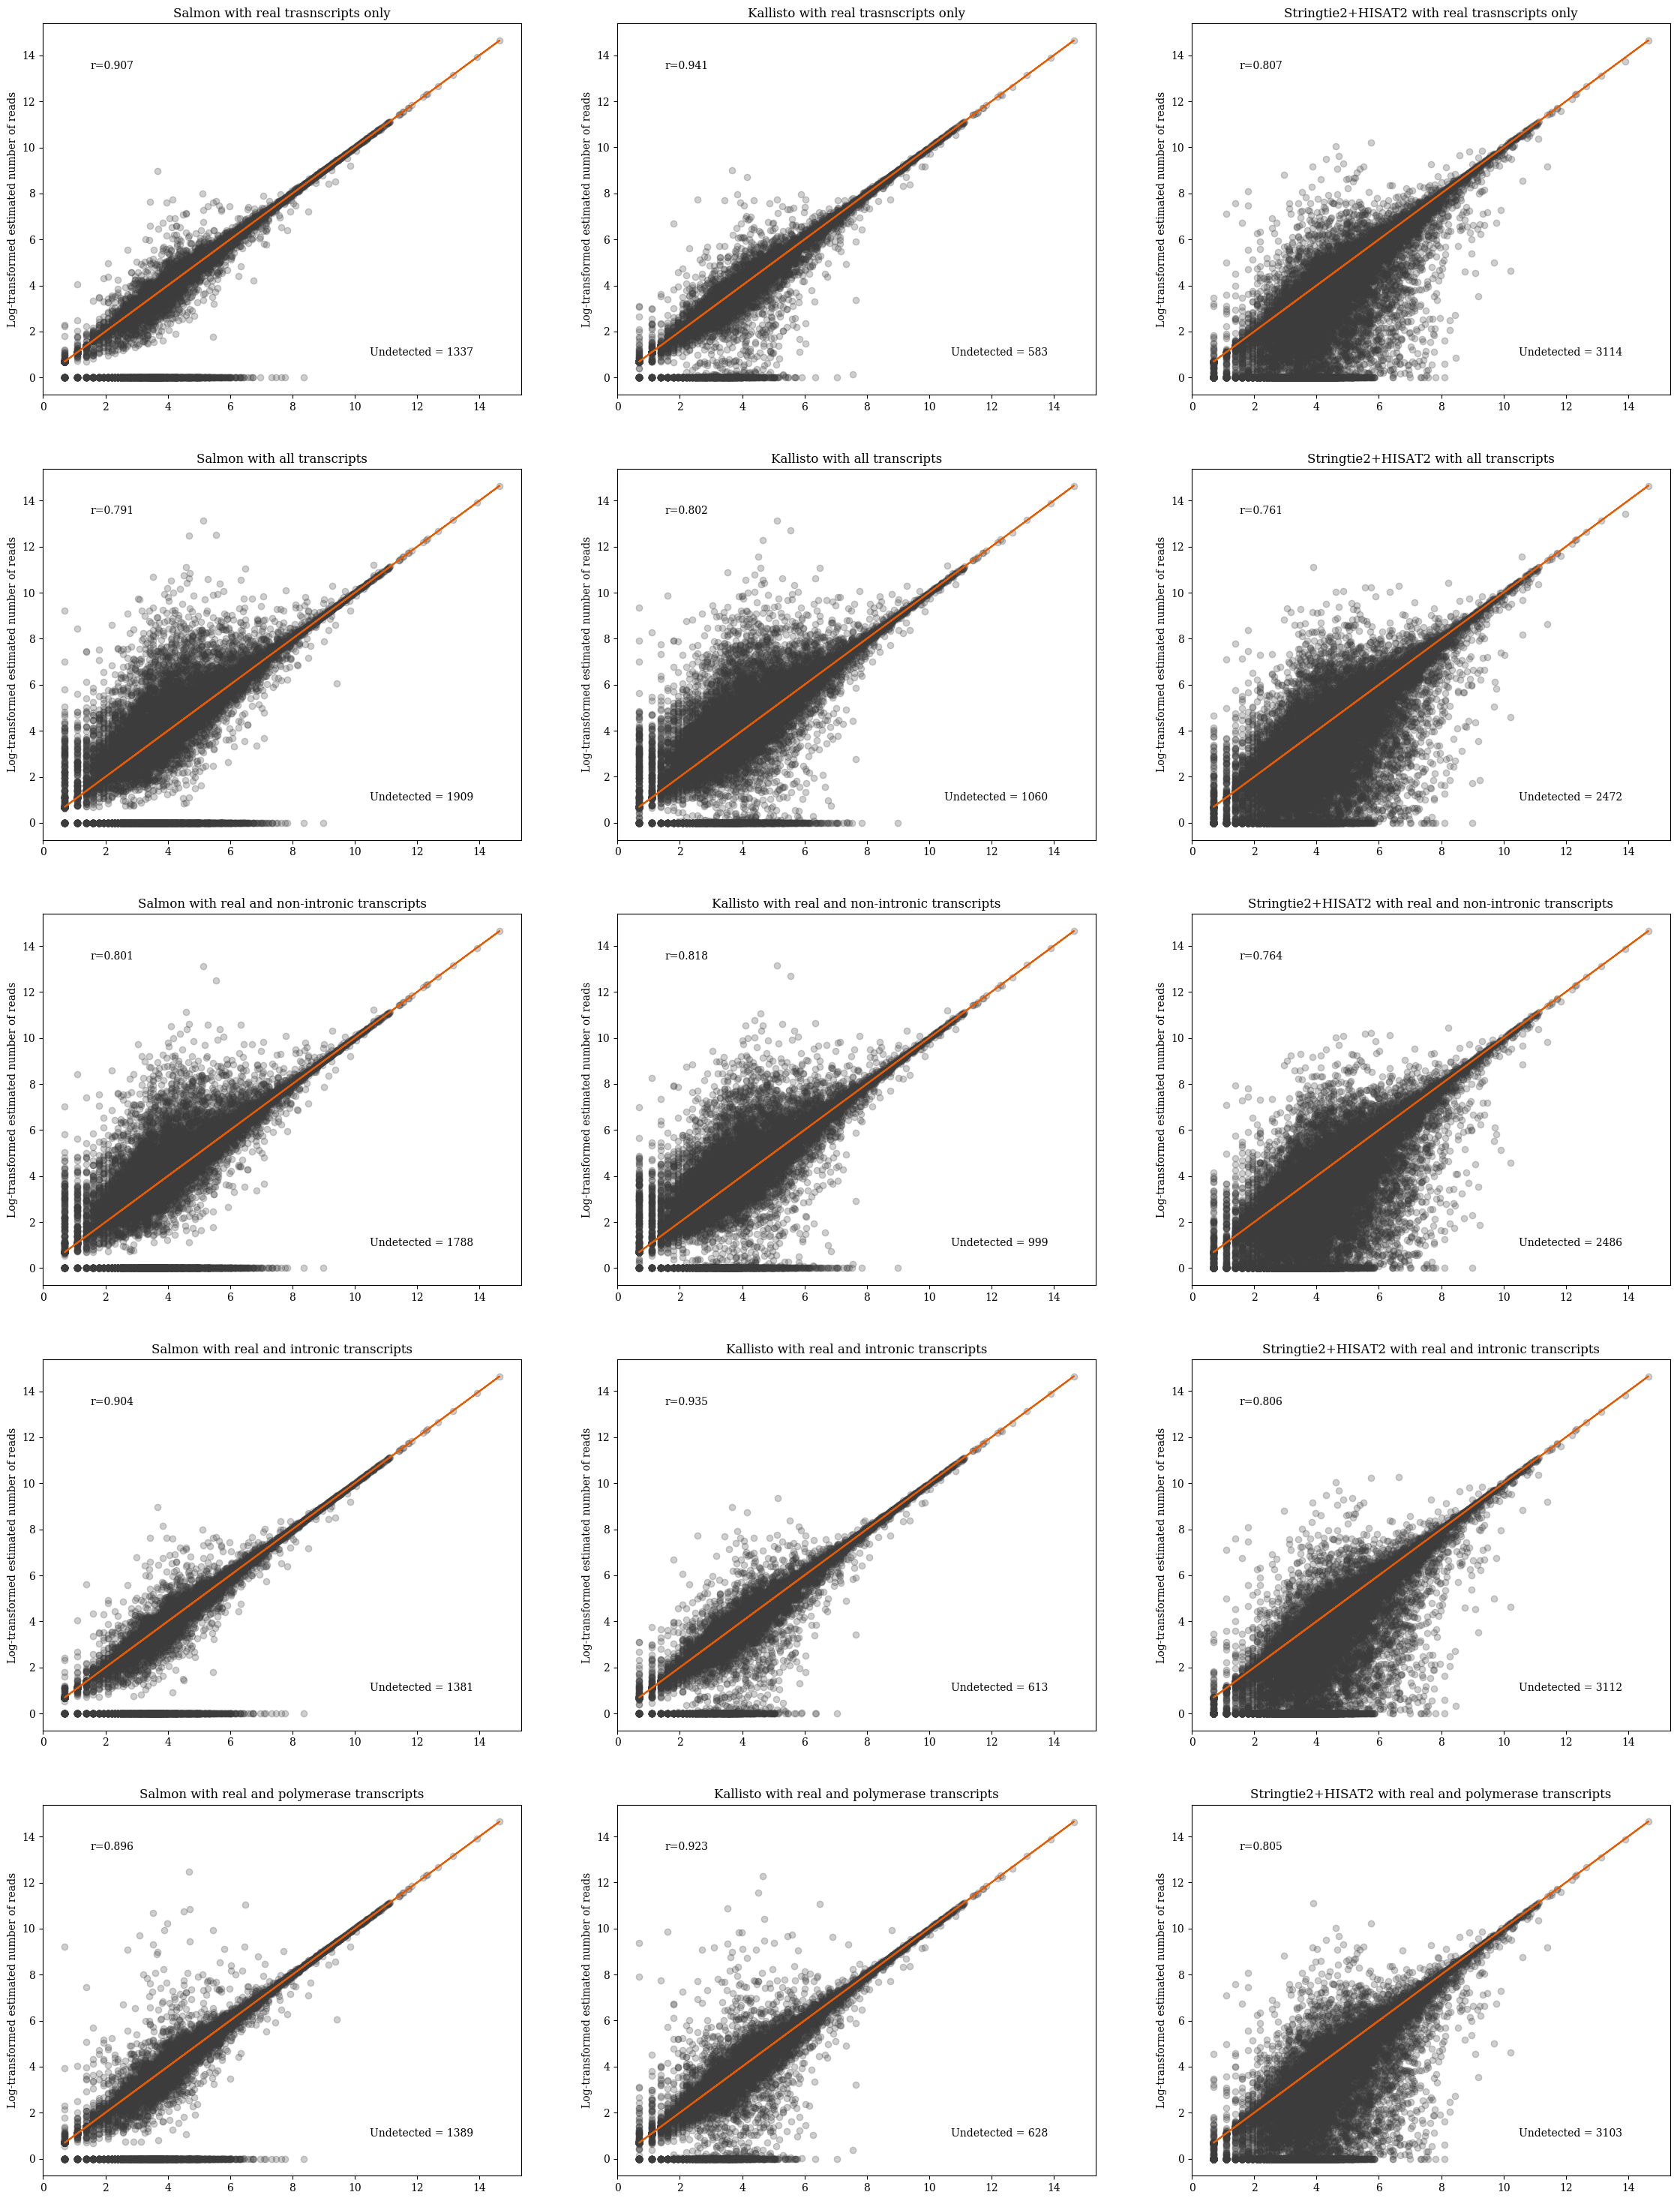

In [20]:
# compare correctness of the alignments
fig1, axes = plt.subplots(ncols=3,nrows=5,figsize=(28,38),dpi=100)

realDF["npairs_log"]=np.log(realDF["npairs"].replace(np.nan,0)+1)
realDF["slmn_real_nreads_log"]=np.log(realDF["slmn_real_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_nreads_log"])
axes[0,0].yaxis.tick_left()
axes[0,0].scatter(realDF["npairs_log"],realDF["slmn_real_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[0,0].set_title("Salmon with real trasnscripts only")
axes[0,0].set_ylabel("Log-transformed estimated number of reads")
axes[0,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[0,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[0,0].transAxes)
axes[0,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_nreads"].isnull())|(realDF["slmn_real_nreads"]==0)]))),ha="right",va="bottom",transform=axes[0,0].transAxes)

realDF["slmn_all_nreads_log"]=np.log(realDF["slmn_all_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_all_nreads_log"])
axes[1,0].yaxis.tick_left()
axes[1,0].scatter(realDF["npairs_log"],realDF["slmn_all_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[1,0].set_title("Salmon with all transcripts")
axes[1,0].set_ylabel("Log-transformed estimated number of reads")
axes[1,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[1,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[1,0].transAxes)
axes[1,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_all_nreads"].isnull())|(realDF["slmn_all_nreads"]==0)]))),ha="right",va="bottom",transform=axes[1,0].transAxes)

realDF["slmn_real_nonint_nreads_log"]=np.log(realDF["slmn_real_nonint_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_nonint_nreads_log"])
axes[2,0].yaxis.tick_left()
axes[2,0].scatter(realDF["npairs_log"],realDF["slmn_real_nonint_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[2,0].set_title("Salmon with real and non-intronic transcripts")
axes[2,0].set_ylabel("Log-transformed estimated number of reads")
axes[2,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[2,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[2,0].transAxes)
axes[2,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_nonint_nreads"].isnull())|(realDF["slmn_real_nonint_nreads"]==0)]))),ha="right",va="bottom",transform=axes[2,0].transAxes)

realDF["slmn_real_int_nreads_log"]=np.log(realDF["slmn_real_int_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_int_nreads_log"])
axes[3,0].yaxis.tick_left()
axes[3,0].scatter(realDF["npairs_log"],realDF["slmn_real_int_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[3,0].set_title("Salmon with real and intronic transcripts")
axes[3,0].set_ylabel("Log-transformed estimated number of reads")
axes[3,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[3,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[3,0].transAxes)
axes[3,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_int_nreads"].isnull())|(realDF["slmn_real_int_nreads"]==0)]))),ha="right",va="bottom",transform=axes[3,0].transAxes)

realDF["slmn_real_pol_nreads_log"]=np.log(realDF["slmn_real_pol_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["slmn_real_pol_nreads_log"])
axes[4,0].yaxis.tick_left()
axes[4,0].scatter(realDF["npairs_log"],realDF["slmn_real_pol_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[4,0].set_title("Salmon with real and polymerase transcripts")
axes[4,0].set_ylabel("Log-transformed estimated number of reads")
axes[4,0].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[4,0].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[4,0].transAxes)
axes[4,0].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["slmn_real_pol_nreads"].isnull())|(realDF["slmn_real_pol_nreads"]==0)]))),ha="right",va="bottom",transform=axes[4,0].transAxes)


realDF["klst_real_nreads_log"]=np.log(realDF["klst_real_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_nreads_log"])
axes[0,1].yaxis.tick_left()
axes[0,1].scatter(realDF["npairs_log"],realDF["klst_real_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[0,1].set_title("Kallisto with real trasnscripts only")
axes[0,1].set_ylabel("Log-transformed estimated number of reads")
axes[0,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[0,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[0,1].transAxes)
axes[0,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_nreads"].isnull())|(realDF["klst_real_nreads"]==0)]))),ha="right",va="bottom",transform=axes[0,1].transAxes)

realDF["klst_all_nreads_log"]=np.log(realDF["klst_all_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_all_nreads_log"])
axes[1,1].yaxis.tick_left()
axes[1,1].scatter(realDF["npairs_log"],realDF["klst_all_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[1,1].set_title("Kallisto with all transcripts")
axes[1,1].set_ylabel("Log-transformed estimated number of reads")
axes[1,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[1,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[1,1].transAxes)
axes[1,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_all_nreads"].isnull())|(realDF["klst_all_nreads"]==0)]))),ha="right",va="bottom",transform=axes[1,1].transAxes)

realDF["klst_real_nonint_nreads_log"]=np.log(realDF["klst_real_nonint_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_nonint_nreads_log"])
axes[2,1].yaxis.tick_left()
axes[2,1].scatter(realDF["npairs_log"],realDF["klst_real_nonint_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[2,1].set_title("Kallisto with real and non-intronic transcripts")
axes[2,1].set_ylabel("Log-transformed estimated number of reads")
axes[2,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[2,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[2,1].transAxes)
axes[2,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_nonint_nreads"].isnull())|(realDF["klst_real_nonint_nreads"]==0)]))),ha="right",va="bottom",transform=axes[2,1].transAxes)

realDF["klst_real_int_nreads_log"]=np.log(realDF["klst_real_int_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_int_nreads_log"])
axes[3,1].yaxis.tick_left()
axes[3,1].scatter(realDF["npairs_log"],realDF["klst_real_int_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[3,1].set_title("Kallisto with real and intronic transcripts")
axes[3,1].set_ylabel("Log-transformed estimated number of reads")
axes[3,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[3,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[3,1].transAxes)
axes[3,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_int_nreads"].isnull())|(realDF["klst_real_int_nreads"]==0)]))),ha="right",va="bottom",transform=axes[3,1].transAxes)

realDF["klst_real_pol_nreads_log"]=np.log(realDF["klst_real_pol_nreads"].replace(np.nan,1)+1)
st=stats.linregress(realDF["npairs_log"],realDF["klst_real_pol_nreads_log"])
axes[4,1].yaxis.tick_left()
axes[4,1].scatter(realDF["npairs_log"],realDF["klst_real_pol_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[4,1].set_title("Kallisto with real and polymerase transcripts")
axes[4,1].set_ylabel("Log-transformed estimated number of reads")
axes[4,1].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[4,1].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[4,1].transAxes)
axes[4,1].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["klst_real_pol_nreads"].isnull())|(realDF["klst_real_pol_nreads"]==0)]))),ha="right",va="bottom",transform=axes[4,1].transAxes)


realDF["strg_real_nreads_log"]=np.log(realDF["strg_real_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_nreads_log"])
axes[0,2].yaxis.tick_left()
axes[0,2].scatter(realDF["npairs_log"],realDF["strg_real_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[0,2].set_title("Stringtie2+HISAT2 with real trasnscripts only")
axes[0,2].set_ylabel("Log-transformed estimated number of reads")
axes[0,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[0,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[0,2].transAxes)
axes[0,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_nreads"].isnull())|(realDF["strg_real_nreads"]==0)]))),ha="right",va="bottom",transform=axes[0,2].transAxes)

realDF["strg_all_nreads_log"]=np.log(realDF["strg_all_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_all_nreads_log"])
axes[1,2].yaxis.tick_left()
axes[1,2].scatter(realDF["npairs_log"],realDF["strg_all_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[1,2].set_title("Stringtie2+HISAT2 with all transcripts")
axes[1,2].set_ylabel("Log-transformed estimated number of reads")
axes[1,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[1,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[1,2].transAxes)
axes[1,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_all_nreads"].isnull())|(realDF["strg_all_nreads"]==0)]))),ha="right",va="bottom",transform=axes[1,2].transAxes)

realDF["strg_real_nonint_nreads_log"]=np.log(realDF["strg_real_nonint_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_nonint_nreads_log"])
axes[2,2].yaxis.tick_left()
axes[2,2].scatter(realDF["npairs_log"],realDF["strg_real_nonint_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[2,2].set_title("Stringtie2+HISAT2 with real and non-intronic transcripts")
axes[2,2].set_ylabel("Log-transformed estimated number of reads")
axes[2,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[2,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[2,2].transAxes)
axes[2,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_nonint_nreads"].isnull())|(realDF["strg_real_nonint_nreads"]==0)]))),ha="right",va="bottom",transform=axes[2,2].transAxes)

realDF["strg_real_int_nreads_log"]=np.log(realDF["strg_real_int_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_int_nreads_log"])
axes[3,2].yaxis.tick_left()
axes[3,2].scatter(realDF["npairs_log"],realDF["strg_real_int_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[3,2].set_title("Stringtie2+HISAT2 with real and intronic transcripts")
axes[3,2].set_ylabel("Log-transformed estimated number of reads")
axes[3,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[3,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[3,2].transAxes)
axes[3,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_int_nreads"].isnull())|(realDF["strg_real_int_nreads"]==0)]))),ha="right",va="bottom",transform=axes[3,2].transAxes)

realDF["strg_real_pol_nreads_log"]=np.log(realDF["strg_real_pol_nreads"].replace(np.nan,0)+1)
st=stats.linregress(realDF["npairs_log"],realDF["strg_real_pol_nreads_log"])
axes[4,2].yaxis.tick_left()
axes[4,2].scatter(realDF["npairs_log"],realDF["strg_real_pol_nreads_log"],alpha=0.25,c="#3C3C3C")
axes[4,2].set_title("Stringtie2+HISAT2 with real and polymerase transcripts")
axes[4,2].set_ylabel("Log-transformed estimated number of reads")
axes[4,2].plot(realDF["npairs_log"],realDF["npairs_log"],"#E75B00")
axes[4,2].text(0.1,0.9,"r="+str(round(st.rvalue,3)),ha='left', va='top', transform=axes[4,2].transAxes)
axes[4,2].text(0.9,0.1,"Undetected = "+str(str(len(realDF[(realDF["strg_real_pol_nreads"].isnull())|(realDF["strg_real_pol_nreads"]==0)]))),ha="right",va="bottom",transform=axes[4,2].transAxes)

# plt.savefig(png_dir+"/readtx.png")